In [1]:
from glob import glob
from tqdm import tqdm
from dask import bag
import ast

from PIL import Image, ImageDraw 

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# Read Files


In [2]:
# get file locations

class_paths = glob('train/*.csv')
print(class_paths)

['train/light bulb.csv', 'train/marker.csv', 'train/whale.csv', 'train/raccoon.csv', 'train/rain.csv', 'train/banana.csv', 'train/giraffe.csv', 'train/train.csv', 'train/roller coaster.csv', 'train/laptop.csv', 'train/belt.csv', 'train/swan.csv', 'train/popsicle.csv', 'train/hand.csv', 'train/bandage.csv', 'train/The Great Wall of China.csv', 'train/paintbrush.csv', 'train/coffee cup.csv', 'train/wine bottle.csv', 'train/door.csv', 'train/cactus.csv', 'train/bee.csv', 'train/bed.csv', 'train/spoon.csv', 'train/bear.csv', 'train/key.csv', 'train/cake.csv', 'train/snail.csv', 'train/toaster.csv', 'train/fork.csv']


In [3]:
# trim the folder name (train/)
# and create the index of categories

nums2names = {i: v[6:-4].replace(" ", "_") for i, v in enumerate(class_paths)} 
names2nums = {v:k for k,v in nums2names.items()}
print(names2nums)

{'light_bulb': 0, 'marker': 1, 'whale': 2, 'raccoon': 3, 'rain': 4, 'banana': 5, 'giraffe': 6, 'train': 7, 'roller_coaster': 8, 'laptop': 9, 'belt': 10, 'swan': 11, 'popsicle': 12, 'hand': 13, 'bandage': 14, 'The_Great_Wall_of_China': 15, 'paintbrush': 16, 'coffee_cup': 17, 'wine_bottle': 18, 'door': 19, 'cactus': 20, 'bee': 21, 'bed': 22, 'spoon': 23, 'bear': 24, 'key': 25, 'cake': 26, 'snail': 27, 'toaster': 28, 'fork': 29}


In [4]:
# get number of class
num_classes = len(names2nums.keys())

# image sizes
imheight, imwidth = 64,64  

# numbers of images in class
ims_per_class = 2000  

## Read Imges

In [6]:
def draw_it(strokes):
    """
    csv to img
    """
    image = Image.new("P", (64, 64), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([int(stroke[0][i]/4), 
                             int(stroke[1][i]/4),
                             int(stroke[0][i+1]/4), 
                             int(stroke[1][i+1]/4)],
                             fill=0, width=2)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

train_grand = []

for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c, nrows=ims_per_class)
    label_name = train.word.values[0]
    label_name = label_name.replace(' ', '_')
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), names2nums[label_name])
    trainarray = np.concatenate((labelarray, trainarray), axis=1) # concate [label, image_array] 
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) 
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

100%|██████████| 30/30 [00:08<00:00,  3.49it/s]


In [7]:
train_grand

array([[29.,  1.,  1., ...,  1.,  1.,  1.],
       [29.,  1.,  1., ...,  1.,  1.,  1.],
       [29.,  0.,  0., ...,  1.,  1.,  1.],
       ...,
       [ 0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 0.,  1.,  1., ...,  1.,  1.,  1.]])

In [8]:
# Seperate label and features

y_train, X_train = train_grand[:, 0], train_grand[:, 1:]
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
print(X_train.shape)


(60000, 4096)
(60000, 64, 64, 1)


# Dataloader

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

from torchvision.utils import make_grid

In [10]:
class Draw(Dataset):
    """
    Dataset Class
    """
    def __init__(self, images, labels, transform=None):
        """
        images [np.array] - (sample sizes, height, width, 1)
        labels [np.array] - (labels,)
        """
        self.transform = transform       
        self.images = torch.tensor(images.reshape(images.shape[0],
                                                  1,
                                                  images.shape[1],
                                                  images.shape[2]
                                                 ),
                                   dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [11]:
# dataset object
dataset = Draw(X_train, y_train)
dataset[0][0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 0., 0.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 1., 1., 1.]]])

In [12]:
# data loader object
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=8
                                         )

## Preview Images

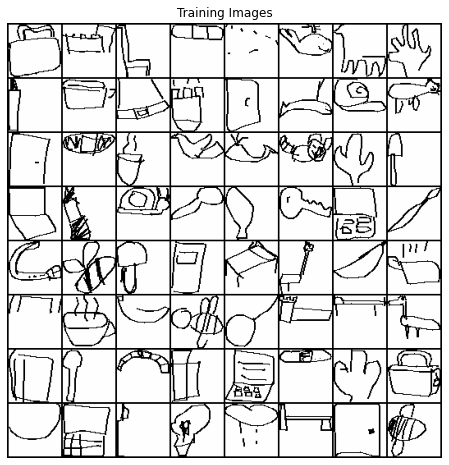

In [13]:
# Plot some training images
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch[0].cpu()[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Model (cDCGAN + Wasserstein GAN)

## Check and Select GPU

In [14]:
torch.cuda.is_available(), torch.cuda.device_count()

(True, 3)

In [25]:
torch.cuda.empty_cache() 
device = 0
torch.device(device), torch.cuda.get_device_name(device)

(device(type='cuda', index=0), 'GeForce RTX 2080 Ti')

## Modeling

In [37]:
import torch.nn as nn

In [38]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 150

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# number of classes
nl = num_classes

In [39]:
# Generator Code

class cDCGenerator(nn.Module):
    def __init__(self):
        super(cDCGenerator, self).__init__()
        
        self.noise_conv =  nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )
        
        self.label_emb = nn.Embedding(nl, nl)
        
        self.label_conv =  nn.Sequential(
            nn.ConvTranspose2d(nl, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(ngf * 4 * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    
    def forward(self, z, labels):
        
        z = z.view(z.size(0), nz, 1, 1)        
        z = self.noise_conv(z)
        c = self.label_emb(labels).view(labels.size(0), nl, 1, 1)
        c = self.label_conv(c)
        x = torch.cat([z, c], 1)
        
        out = self.model(x)
        return out.view(x.size(0), 64, 64)
    
class cDCDiscriminator(nn.Module):
    def __init__(self):
        super(cDCDiscriminator, self).__init__()
        
        self.img_conv =  nn.Sequential(
            # input is 64*64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
                
        self.label_conv =  nn.Sequential(
            # input is 64*64
            nn.Conv2d(nl, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.main = nn.Sequential(
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid() wgan version
        )

    def forward(self, input, labels):    
        img_feature = self.img_conv(input)
        lab_feature = self.label_conv(labels)
        con_feature = torch.cat([img_feature, lab_feature], 1)
        
        out = self.main(con_feature)
        return out.squeeze()


### Initialize model

In [40]:
# custom weights initialization called on netG and netD
def weights_init_DC(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.5)
        nn.init.constant_(m.bias.data, 0)

cdcgenerator = cDCGenerator().cuda(device=torch.device(device))
cdcdiscriminator = cDCDiscriminator().cuda(device=torch.device(device))

cdcgenerator.apply(weights_init_DC)
cdcdiscriminator.apply(weights_init_DC)

print(cdcgenerator, cdcdiscriminator)

cDCGenerator(
  (noise_conv): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (label_emb): Embedding(30, 30)
  (label_conv): Sequential(
    (0): ConvTranspose2d(30, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, k

### Learning 

In [41]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(25, nz, 1, 1).cuda(device=torch.device(device))
fix_label = torch.arange(25).cuda(device=torch.device(device))

print(fix_label) # see temporary result for each batch

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(cdcdiscriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(cdcgenerator.parameters(), lr=lr, betas=(beta1, 0.999))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24], device='cuda:0')


### Additional material for cDCGAN

In [42]:
# set the condition channel for CDCGAN

fill = torch.zeros([nl, nl, image_size, image_size]).cuda(device=torch.device(device))
for i in range(nl):
    fill[i, i, :, :] = 1


# Training

In [43]:
from tqdm import tqdm_notebook

# to monitoring
def monitor_generation(epoch, cdcgenerator, numstonames):    
    print("\n----","Result After Epoch:", epoch+1, "----")
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(make_grid(cdcgenerator(noise, y_)[:64].cpu().detach().view(64, 1, 64, 64), padding=2, normalize=True), (1,2,0)))
    for i, y in enumerate(y_[:64].cpu()):
        if i%8==7:
            print(numstonames[int(y)], end='\n\n')
        else:
            print(numstonames[int(y)],  end='\t')
    plt.show()
    plt.close()
    print("----\n")

# To record the training

img_list = []
G_losses = []
D_losses = []

Starting Training Loop...


[0/150][0/469]	Loss_D: -0.3953	Loss_G: -0.0094	D(x): -0.5382	D(G(z)): -0.9336 / -0.0094
[0/150][150/469]	Loss_D: -2.2190	Loss_G: -1.2752	D(x): 0.9656	D(G(z)): -1.2534 / -1.2752
[0/150][300/469]	Loss_D: -1.3250	Loss_G: 0.3272	D(x): 0.0554	D(G(z)): -1.2696 / 0.3272
[0/150][450/469]	Loss_D: -1.7145	Loss_G: -1.4134	D(x): 1.3293	D(G(z)): -0.3852 / -1.4134


---- Result After Epoch: 1 ----
whale	rain	train	door	wine_bottle	bear	giraffe	door

spoon	toaster	belt	bear	light_bulb	laptop	coffee_cup	banana

giraffe	wine_bottle	giraffe	train	train	bed	marker	swan

bed	marker	roller_coaster	wine_bottle	popsicle	rain	cake	roller_coaster

cake	banana	hand	giraffe	banana	bee	bear	bee

paintbrush	train	paintbrush	giraffe	bandage	paintbrush	fork	swan

swan	raccoon	whale	door	whale	marker	light_bulb	hand

The_Great_Wall_of_China	train	light_bulb	laptop	light_bulb	cake	door	wine_bottle



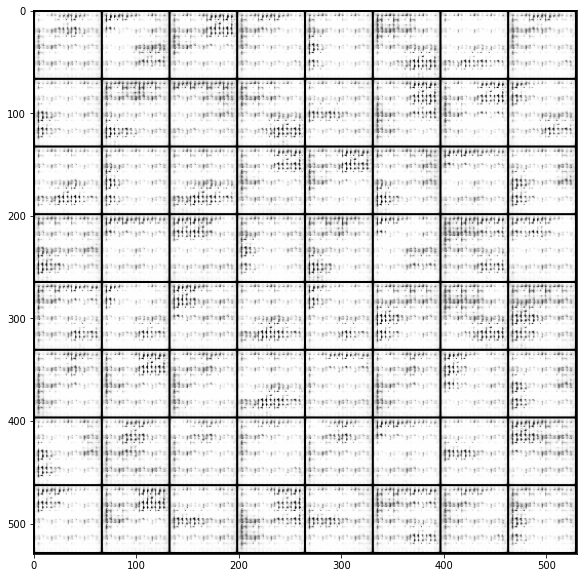

----



[1/150][0/469]	Loss_D: -2.6065	Loss_G: -1.4227	D(x): 1.2629	D(G(z)): -1.3436 / -1.4227
[1/150][150/469]	Loss_D: -2.6153	Loss_G: -1.5028	D(x): 1.4311	D(G(z)): -1.1842 / -1.5028
[1/150][300/469]	Loss_D: -2.4876	Loss_G: -1.4292	D(x): 1.0678	D(G(z)): -1.4198 / -1.4292
[1/150][450/469]	Loss_D: -2.5179	Loss_G: -1.4498	D(x): 1.1843	D(G(z)): -1.3336 / -1.4498



[2/150][0/469]	Loss_D: -2.8014	Loss_G: -1.4677	D(x): 1.3762	D(G(z)): -1.4252 / -1.4677
[2/150][150/469]	Loss_D: -2.8767	Loss_G: -1.4830	D(x): 1.4821	D(G(z)): -1.3946 / -1.4830
[2/150][300/469]	Loss_D: -2.9904	Loss_G: -1.5121	D(x): 1.4975	D(G(z)): -1.4929 / -1.5121
[2/150][450/469]	Loss_D: -0.7863	Loss_G: -1.1561	D(x): 0.1811	D(G(z)): -0.6052 / -1.1561



[3/150][0/469]	Loss_D: -2.3586	Loss_G: -1.2779	D(x): 0.9798	D(G(z)): -1.3788 / -1.2779
[3/150][150/469]	Loss_D: -2.5198	Loss_G: -1.3974	D(x): 1.3384	D(G(z)): -1.1814 / -1.3974
[3/150][300/469]	Loss_D: -2.4181	Loss_G: -1.2191	D(x): 1.2106	D(G(z)): -1.2075 / -1.2191
[3/150][450/469]	Loss_D: -2.3957	Loss_G: -1.4739	D(x): 1.3654	D(G(z)): -1.0304 / -1.4739



[4/150][0/469]	Loss_D: -1.4379	Loss_G: -0.1807	D(x): 0.0276	D(G(z)): -1.4103 / -0.1807
[4/150][150/469]	Loss_D: -1.8757	Loss_G: -0.7967	D(x): 0.5086	D(G(z)): -1.3670 / -0.7967
[4/150][300/469]	Loss_D: -2.0647	Loss_G: -1.4176	D(x): 1.3480	D(G(z)): -0.7167 / -1.4176
[4/150][450/469]	Loss_D: -2.3355	Loss_G: -1.2802	D(x): 1.1060	D(G(z)): -1.2295 / -1.2802



[5/150][0/469]	Loss_D: -2.3519	Loss_G: -1.1169	D(x): 0.9820	D(G(z)): -1.3699 / -1.1169
[5/150][150/469]	Loss_D: -2.5244	Loss_G: -1.3678	D(x): 1.2578	D(G(z)): -1.2666 / -1.3678
[5/150][300/469]	Loss_D: -2.5286	Loss_G: -1.3358	D(x): 1.2190	D(G(z)): -1.3096 / -1.3358
[5/150][450/469]	Loss_D: -2.3805	Loss_G: -1.4191	D(x): 1.3188	D(G(z)): -1.0617 / -1.4191



[6/150][0/469]	Loss_D: -2.4291	Loss_G: -1.1870	D(x): 1.1189	D(G(z)): -1.3102 / -1.1870
[6/150][150/469]	Loss_D: -2.1384	Loss_G: -1.4232	D(x): 1.3890	D(G(z)): -0.7493 / -1.4232
[6/150][300/469]	Loss_D: -2.5585	Loss_G: -1.2941	D(x): 1.1858	D(G(z)): -1.3727 / -1.2941
[6/150][450/469]	Loss_D: -2.6696	Loss_G: -1.4364	D(x): 1.3585	D(G(z)): -1.3111 / -1.4364



[7/150][0/469]	Loss_D: -2.6046	Loss_G: -1.3461	D(x): 1.2100	D(G(z)): -1.3946 / -1.3461
[7/150][150/469]	Loss_D: -2.6590	Loss_G: -1.3926	D(x): 1.3155	D(G(z)): -1.3434 / -1.3926
[7/150][300/469]	Loss_D: -2.6370	Loss_G: -1.3713	D(x): 1.2701	D(G(z)): -1.3669 / -1.3713
[7/150][450/469]	Loss_D: -2.5731	Loss_G: -1.2351	D(x): 1.1753	D(G(z)): -1.3977 / -1.2351



[8/150][0/469]	Loss_D: -2.4986	Loss_G: -1.4419	D(x): 1.3647	D(G(z)): -1.1339 / -1.4419
[8/150][150/469]	Loss_D: -2.4921	Loss_G: -1.4515	D(x): 1.3524	D(G(z)): -1.1397 / -1.4515
[8/150][300/469]	Loss_D: -2.4969	Loss_G: -1.3409	D(x): 1.1316	D(G(z)): -1.3653 / -1.3409
[8/150][450/469]	Loss_D: -2.5702	Loss_G: -1.3934	D(x): 1.2991	D(G(z)): -1.2711 / -1.3934



[9/150][0/469]	Loss_D: -1.6461	Loss_G: -1.1001	D(x): 0.1889	D(G(z)): -1.4572 / -1.1001
[9/150][150/469]	Loss_D: -2.5788	Loss_G: -1.3881	D(x): 1.3193	D(G(z)): -1.2595 / -1.3881
[9/150][300/469]	Loss_D: -2.5983	Loss_G: -1.4196	D(x): 1.3606	D(G(z)): -1.2377 / -1.4196
[9/150][450/469]	Loss_D: -1.8706	Loss_G: -0.7864	D(x): 0.4294	D(G(z)): -1.4412 / -0.7864



[10/150][0/469]	Loss_D: -1.5889	Loss_G: -1.4307	D(x): 1.3893	D(G(z)): -0.1996 / -1.4307
[10/150][150/469]	Loss_D: -2.5628	Loss_G: -1.4056	D(x): 1.3281	D(G(z)): -1.2348 / -1.4056
[10/150][300/469]	Loss_D: -2.4201	Loss_G: -1.2518	D(x): 1.0190	D(G(z)): -1.4012 / -1.2518
[10/150][450/469]	Loss_D: -2.6752	Loss_G: -1.4110	D(x): 1.3401	D(G(z)): -1.3351 / -1.4110



[11/150][0/469]	Loss_D: -2.4229	Loss_G: -1.4567	D(x): 1.3966	D(G(z)): -1.0262 / -1.4567
[11/150][150/469]	Loss_D: -2.5099	Loss_G: -1.2075	D(x): 1.0961	D(G(z)): -1.4139 / -1.2075
[11/150][300/469]	Loss_D: -2.2130	Loss_G: -1.4391	D(x): 1.3967	D(G(z)): -0.8163 / -1.4391
[11/150][450/469]	Loss_D: -2.6272	Loss_G: -1.3925	D(x): 1.3416	D(G(z)): -1.2856 / -1.3925



[12/150][0/469]	Loss_D: -2.3737	Loss_G: -1.3396	D(x): 1.2508	D(G(z)): -1.1229 / -1.3396
[12/150][150/469]	Loss_D: -2.5342	Loss_G: -1.4051	D(x): 1.3420	D(G(z)): -1.1922 / -1.4051
[12/150][300/469]	Loss_D: -2.6704	Loss_G: -1.4374	D(x): 1.3614	D(G(z)): -1.3090 / -1.4374
[12/150][450/469]	Loss_D: -2.6150	Loss_G: -1.3908	D(x): 1.3278	D(G(z)): -1.2872 / -1.3908



[13/150][0/469]	Loss_D: -2.1692	Loss_G: -0.1872	D(x): 0.7399	D(G(z)): -1.4293 / -0.1872
[13/150][150/469]	Loss_D: -2.5923	Loss_G: -1.2232	D(x): 1.1582	D(G(z)): -1.4342 / -1.2232
[13/150][300/469]	Loss_D: -2.4008	Loss_G: -1.2443	D(x): 0.9614	D(G(z)): -1.4394 / -1.2443
[13/150][450/469]	Loss_D: -2.6257	Loss_G: -1.3936	D(x): 1.2780	D(G(z)): -1.3477 / -1.3936



[14/150][0/469]	Loss_D: -2.6348	Loss_G: -1.2694	D(x): 1.2221	D(G(z)): -1.4127 / -1.2694
[14/150][150/469]	Loss_D: -2.6871	Loss_G: -1.3783	D(x): 1.2735	D(G(z)): -1.4136 / -1.3783


In [ ]:
# Training Loop

# Lists to keep track of progress
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (images, y_) in tqdm_notebook(enumerate(data_loader, 0)):
        y_ = y_.cuda(device=torch.device(device))
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        cdcdiscriminator.zero_grad()
        # Format batch
        real_cpu = images.cuda(device=torch.device(device)).view(images.size()[0], 1, 64, 64)
        b_size = real_cpu.size(0)
        y_fill_ = fill[y_]
        label = torch.full((b_size,), real_label).cuda(device=torch.device(device))
        
        # Forward pass real batch through D
        errD_real = cdcdiscriminator(real_cpu, y_fill_).view(-1).mean() # wgan real_loss
        output = errD_real 
        
        # Calculate loss on all-real batch
        D_x = output.item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1).cuda(device=torch.device(device))
        # Generate fake image batch with G
        fake = cdcgenerator(noise, y_).view(b_size, 1, 64, 64)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        errD_fake = cdcdiscriminator(fake.detach(), y_fill_).view(-1).mean() # wgan fake_loss
        output = errD_fake
        
        # Calculate D's loss on the all-fake batch
        D_G_z1 = output.item()
    
        # Add the gradients from the all-real and all-fake batches    
        d_loss = - errD_real + errD_fake
        d_loss.backward()
        # Update D
        for p in cdcdiscriminator.parameters(): p.data.clamp_(-0.01, 0.01)
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        cdcgenerator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        # Since we just updated D, perform another forward pass of all-fake batch through D
        errG = cdcdiscriminator(fake, y_fill_).view(-1).mean() # wgan fake_loss
        output = errG
        
        # Calculate G's loss based on this output
        g_loss = - errG
        g_loss.backward()
        D_G_z2 = output.item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 150 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(data_loader),
                     d_loss.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(-d_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 230 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = cdcgenerator(fixed_noise, fix_label).detach().cpu().view(fixed_noise.size(0), nc, image_size, image_size)
            img_list.append(make_grid(fake, padding=2, nrow=5, normalize=True))
        iters += 1
        
        # END batch
        
    if epoch % 50 ==0:
        monitor_generation(epoch, cdcgenerator, nums2names)
    # END Epoch